In [1]:
import os
from tqdm import tqdm
from glob import glob
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep

Welcome to JupyROOT 6.24/06


# Event Loop
-----------------------
In the following cells, the 'event_loop' function performs object selection and event selection for data and MC files,\
and saves them in root files


I have followed these refs for selections
- http://opendata.atlas.cern/release/2020/documentation/datasets/objects.html
- https://arxiv.org/abs/2207.00320

Selections
- Object Selection
    - Electron
        - $p_{T}$ > 7 GeV, -2.47 < $\eta$ < 2.47
    - Muon
        - $p_{T}$ > 7 GeV, -2.5 < $\eta$ < 2.5
        
- Event Selection
    - Satisfying electron or muon triggers
    - Exactly four leptons with $p_{T}$ > 25, 15, 10, 7 GeV respectively
    - $\Delta R(\textit{l}, \textit{l'})$ > 0.1 for possible lepton pair
    - Events with two Z pairs (same flavour, opposite charge)
    

In [2]:
def event_loop(file_lst, ran, out_name, isData=True):
    m_z = 91 * 1000
    lumi = 10
    chain = r.TChain("mini")
    
    for file in file_lst:
        chain.Add(file)
    
    n_tot_event, n_selected_event = 0, 0
    h_4l = r.TH1F("tot_4l", r"ZZ*#rightarrow4l;m_{4l} [GeV];Events", *ran)
    h_mmmm = r.TH1F("mmmm", r"ZZ*#rightarrow#mu#mu#mu#mu;m_{4l} [GeV];Events", *ran)
    h_em = r.TH1F("em", r"ZZ*#rightarrow(#mu#muee or ee#mu#mu);m_{4l} [GeV];Events", *ran)
    h_mmee = r.TH1F("mmee", r"ZZ*#rightarrow#mu#muee;m_{4l} [GeV];Events", *ran)
    h_eemm = r.TH1F("eemm", r"ZZ*#rightarrowee#mu#mu;m_{4l} [GeV];Events", *ran)
    h_eeee = r.TH1F("eeee", r"ZZ*#rightarroweeee;m_{4l} [GeV];Events", *ran)

    for ev in tqdm(chain, total=chain.GetEntries()):
        n_tot_event +=1
        pid = np.array([])
        lep_4vec = np.array([])
        charge = np.array([])

        # LEPTON TRIGGER
        if not (ev.trigE or ev.trigM): continue

        # Object Selection
        for idx in range(len(ev.lep_pt)):
            if ev.lep_type[idx] == 11:  # ELECTRON
                if ev.lep_pt[idx] < 7000 or abs(ev.lep_eta[idx]) > 2.47: continue
            elif ev.lep_type[idx] == 13:  # MUON
                if ev.lep_pt[idx] < 7000 or abs(ev.lep_eta[idx]) > 2.5: continue
                # if ((ev.lep_ptcone30[idx]) > 0.15 * ev.lep_pt[idx]): continue  # Loose cut                
                # if ((ev.lep_etcone20[idx]) > 0.15 * ev.lep_pt[idx]): continue  # Loose cut                                
                # if ((ev.lep_ptcone30[idx] + 0.4*ev.lep_etcone20[idx]) > 0.16 * ev.lep_pt[idx]): continue  # PflowLoose cut
            else: continue                


            lep = r.TLorentzVector()
            lep.SetPtEtaPhiE(ev.lep_pt[idx],
                             ev.lep_eta[idx],
                             ev.lep_phi[idx],
                             ev.lep_E[idx])
            pid = np.append(pid, ev.lep_type[idx])
            lep_4vec = np.append(lep_4vec, lep)
            charge = np.append(charge, ev.lep_charge[idx])

        # Event Selection
        if len(lep_4vec) != 4: continue        
        if lep_4vec[0].Pt() < 25000\
            or lep_4vec[1].Pt() < 15000\
            or lep_4vec[2].Pt() < 10000\
            or lep_4vec[3].Pt() < 7000:
            continue

        # SAME-FLAVOUR OPPOSITE-CHARGE
        if (sum(charge[pid==11]) != 0) or (sum(charge[pid==13]) != 0): continue
        
        # DELTA R CUT FOR EACH LEPTON PAIR 
        for i in range(3):
            lep0 = lep_4vec[i]
            for j in range(i+1, 4):
                lep1 = lep_4vec[j]
                if lep0.DeltaR(lep1) < 0.1: 
                    continue

        # 4LEPTON MASS
        m_4l = (lep_4vec[0] + lep_4vec[1] + lep_4vec[2] + lep_4vec[3]).M() / 1000
        
        weight = 1 if isData else ev.mcWeight / ev.SumWeights * ev.XSection * lumi * 1000
        if sum(pid) == 44:  # ZZ --> ee ee
            h_eeee.Fill(m_4l, weight)
        elif sum(pid) == 52:  # ZZ --> mumu mumu
            h_mmmm.Fill(m_4l, weight)
        elif sum(pid) == 48:
            h_em.Fill(m_4l)  # ZZ --> mm ee or ee mm
            elel = lep_4vec[pid==11][0] + lep_4vec[pid==11][1]
            mumu = lep_4vec[pid==13][0] + lep_4vec[pid==13][1]
            if abs(m_z - elel.M()) < abs(m_z - mumu.M()):
                h_eemm.Fill(m_4l, weight)  # ZZ --> ee mumu
            else:
                h_mmee.Fill(m_4l, weight)  # ZZ --> mumu ee 
        else:
            continue

        h_4l.Fill(m_4l, weight)
        n_selected_event += 1
    
    hist_lst = [h_4l, h_eeee, h_eemm, h_mmee, h_mmmm, h_em]

    f = r.TFile.Open(f"{out_name}.root", "RECREATE")
    for hist in hist_lst:
        f.WriteObject(hist, hist.GetName())
    f.Close()

    print(f"{n_tot_event}, {n_selected_event}")  


### Running the 'event_loop()' Function
----------------------------------
Here, I run the function with the following MC samples from this link. (4lepton final states were used)\
http://opendata.atlas.cern/release/2020/documentation/datasets/mc.html 

In [3]:
mc_path = "/store/ml/datasets/opendata/4lep/MC/"

# SM HIGGS PRODUCTION (H --> ZZ --> 4l)
mc_sig_lst = [mc_path + sample for sample in ['mc_341947.ZH125_ZZ4lep.4lep.root',
                                              'mc_341964.WH125_ZZ4lep.4lep.root',
                                              'mc_344235.VBFH125_ZZ4lep.4lep.root',
                                              'mc_345060.ggH125_ZZ4lep.4lep.root',]]
# DIBOSON PRODUCTION (ZZ --> 4l)
mc_bkg_lst = [mc_path + sample for sample in ['mc_363490.llll.4lep.root']]

data_path = "/store/ml/datasets/opendata/4lep/Data/*"
data_lst = glob(data_path)

ran = [24, 80, 170]
event_loop(data_lst, ran, out_name='data', isData=True)
event_loop(mc_sig_lst, ran, out_name='mc_sig', isData=False)
event_loop(mc_bkg_lst, ran, out_name='mc_bkg', isData=False)

  0%|          | 80/385706 [00:00<08:04, 796.23it/s]

832, 429


  0%|          | 0/554279 [00:00<?, ?it/s]

385706, 353130


100%|██████████| 554279/554279 [06:51<00:00, 1347.14it/s]


554279, 487772


### Event Yeild After Selection
--------------------------
Here, we can see the event yeilds of data and MC aftere selections

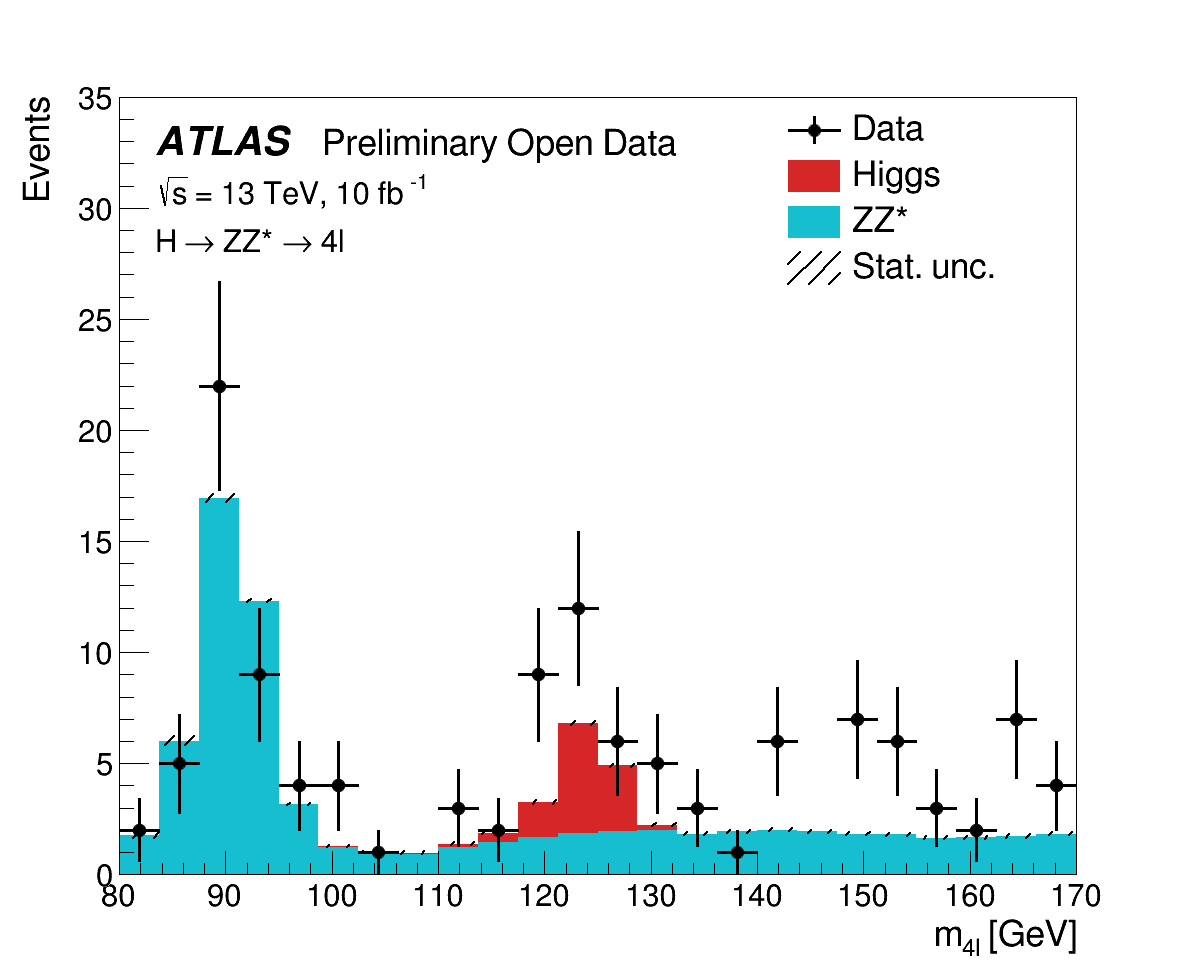

In [4]:
import matplotlib.colors as mcolors

# LOAD HISTOS
channel = 'tot_4l'
data = r.TFile.Open('data2.root')
mc_sig = r.TFile.Open('mc_sig.root')
mc_bkg = r.TFile.Open('mc_bkg.root')
h_data = data.Get(channel)
h_sig = mc_sig.Get(channel)
h_bkg = mc_bkg.Get(channel)
cvs = r.TCanvas('', '', 1200, 1000)

# MC STATISTIC ERROR BAND
r.gStyle.SetHatchesLineWidth(2)
h = h_sig.Clone()
h.Reset()
h.Add(h_sig)
h.Add(h_bkg)

nbins=h.GetNbinsX()
errorband_main = r.TGraphAsymmErrors(h)
errorband_main.SetFillColor(r.kBlack)
errorband_main.SetFillStyle(3454)
errorband_main.SetLineWidth(0)
for ib in range(nbins):
    error = h.GetBinError(ib+1)
    errorband_main.SetPointEYhigh(ib-1, error)
    errorband_main.SetPointEYlow(ib-1, error)
    errorband_main.SetPointEXhigh(ib-1, 0.5*h.GetBinWidth(ib))
    errorband_main.SetPointEXlow(ib-1, 0.5*h.GetBinWidth(ib))

# STACK MC BKG & SIG
ths = r.THStack()
h_sig.SetLineColorAlpha(0, 0)
h_sig.SetFillColor(r.TColor.GetColor(mcolors.to_hex(mcolors.TABLEAU_COLORS['tab:red'])))
h_bkg.SetLineColorAlpha(0, 0)
h_bkg.SetFillColor(r.TColor.GetColor(mcolors.to_hex(mcolors.TABLEAU_COLORS['tab:cyan'])))
ths.Add(h_bkg)
ths.Add(h_sig)

# DRAW PLOTS
h_data.SetStats(0)
h_data.SetTitle('')
h_data.SetAxisRange(0, 35, 'Y')
h_data.SetMarkerStyle(20)
h_data.SetMarkerSize(1.5)
h_data.SetLineWidth(3)
h_data.SetLineColor(r.kBlack)
h_data.GetXaxis().SetTitleSize(0.04)
h_data.GetYaxis().SetTitleSize(0.04)

h_data.Draw('ep')
ths.Draw('samehist')
h_data.Draw('epsame')
errorband_main.Draw('e2same')

leg = r.TLegend(0.65, 0.7, 0.9, 0.89)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(h_data, 'Data', 'lep')
leg.AddEntry(h_sig, 'Higgs', 'f')
leg.AddEntry(h_bkg, 'ZZ*', 'f')
leg.AddEntry(errorband_main, 'Stat. unc.', 'f')
leg.Draw("")

# Add ATLAS label
text = r.TLatex()
text.SetNDC()
text.SetTextFont(72)
text.SetTextSize(0.045)
text.DrawLatex(0.13, 0.84, "ATLAS")

text.SetTextFont(42)
text.SetTextSize(0.04)
text.DrawLatex(0.13 + 0.14, 0.84, "Preliminary Open Data")

text.SetTextSize(0.035)
text.DrawLatex(0.13, 0.79, "#sqrt{s} = 13 TeV, 10 fb^{-1}");

text.SetTextSize(0.035)
text.DrawLatex(0.13, 0.74, r"H #rightarrow ZZ* #rightarrow 4l");


cvs.RedrawAxis()
cvs.Draw()

# Fit functions
----------------------------------
First of all, I fit the signal MC with gaussian function

and then, I fit the background MC with two gaussian function.

Using the parameters from the MC fits, I fit the data with three gaussian function\
(1. Z boson peak, 2. flatten region after 100 GeV, 3. Signal)

I limit the strength of each gaussian between 0 to 1000, because to prevent it became negative sign

I set the Higgs mass scan range between 105 GeV to 170 GeV


In [5]:
def fit_sig(h, ran):
    h.Draw('e'); h.SetMinimum(0)
    sfn = r.TF1('signal', '[0]*TMath::Gaus(x,[1],[2],1)', *ran[1:])
    sfn.SetParameter(0, 1)
    sfn.SetParameter(1, 125)
    sfn.SetParameter(2, 2)
    sres = h.Fit(sfn, "MINOS S").Get()
    print(f"mean: {sres.Parameter(1):.3f} +- {sres.ParError(1):.3f}")
    print(f"sigma:{sres.Parameter(2):.3f} +- {sres.ParError(2):.3f}")
    return sres.Parameter(1), sres.Parameter(2)

In [6]:
def fit_bkg(h, ran):
    h.Draw('e'); h.SetMinimum(0)
    sfn = r.TF1('bkg', '[0]*TMath::Gaus(x,[1],[2],1) + [3]*TMath::Gaus(x,[4],[5],1)', *ran[1:])
    sfn.SetParameter(0, 1)
    sfn.SetParameter(1, 90)
    sfn.SetParLimits(1, 80, 100)
    sfn.SetParameter(2, 2)
    sfn.SetParameter(3, 10)
    sfn.SetParameter(4, 160)
    sfn.SetParLimits(4, 100, 200)
    sfn.SetParameter(5, 50)
    sres = h.Fit(sfn, "MINOS S").Get()
    print("Z boson peak")
    print(f"mean: {sres.Parameter(1):.3f} +- {sres.ParError(1):.3f}")
    print(f"sigma:{sres.Parameter(2):.3f} +- {sres.ParError(2):.3f}")
    print("flatten area")
    print(f"mean: {sres.Parameter(4):.3f} +- {sres.ParError(4):.3f}")
    print(f"sigma:{sres.Parameter(5):.3f} +- {sres.ParError(5):.3f}")
    return sres.Parameter(1), sres.Parameter(2), sres.Parameter(4), sres.Parameter(5)

In [7]:
def fit(hm, ran, sig_fitval, bkg_fitval):
    p_value_dict = {}
    z_value_dict = {}
    cvs = r.TCanvas()
    scan_ran = [105, 170]
    min_p = 2
    for m_higgs in np.arange(*scan_ran, 0.25):
        bfn = r.TF1('background', '[0]*TMath::Gaus(x,[1],[2],1) + [3]*TMath::Gaus(x,[4],[5],1)', *ran[1:])
        bfn.SetParameter(1, bkg_fitval[0])
        bfn.SetParameter(2, bkg_fitval[1])
        bfn.SetParameter(4, bkg_fitval[2])
        bfn.SetParameter(5, bkg_fitval[3])        
        bres = hm.Fit(bfn, "MINOS S").Get()     
        
        mfn = r.TF1('fit', '[0]*TMath::Gaus(x,[1],[2],1) + [3]*TMath::Gaus(x,[4],[5],1) + [6]*TMath::Gaus(x,[7],[8],1)', *ran[1:])
        mfn.SetParameter(1, bkg_fitval[0])
        mfn.SetParameter(2, bkg_fitval[1])
        mfn.SetParameter(4, bkg_fitval[2])
        mfn.SetParameter(5, bkg_fitval[3])
        
        mfn.FixParameter(7, m_higgs)
        mfn.FixParameter(8, sig_fitval[1])
        
        mfn.SetParLimits(0, 0, 1000)
        mfn.SetParLimits(3, 0, 1000)
        mfn.SetParLimits(6, 0, 1000)        
        mres = hm.Fit(mfn, "MINOS S").Get()

        for i in range(6):
            bfn.SetParameter(i, mres.Parameter(i))
            
        sfn = r.TF1('signal', f'[0]*TMath::Gaus(x,{sig_fitval[0]},{sig_fitval[1]},1)', *ran[1:])
        
        for i in range(1):
            sfn.SetParameter(i, mfn.GetParameter(6+i))
        hm.Sumw2(); res = hm.Clone()

        for i in range(1,res.GetNbinsX()+1):
            res.SetBinContent(i, hm.GetBinContent(i)-bfn.Eval(hm.GetBinCenter(i)))

        delta = bres.Chi2() - mres.Chi2()
        p = r.Math.chisquared_cdf_c(delta, bres.Ndf() - mres.Ndf())
        p_value_dict[m_higgs] = p
        
        if p < min_p:
            res.Draw("E")
            sfn.Draw('same')
            res.SetMinimum(-8)
            res.SetMaximum(+20)
            cvs.SaveAs(f"{hm.GetName()}_res.png")

            hm.Draw('ep')
            hm.SetMinimum(0)
            mfn.Draw('same')
            bfn.SetLineColor(r.kBlack)
            bfn.SetLineStyle(r.kDotted); bfn.Draw('same')
            cvs.SaveAs(f"{hm.GetName()}_bkgfit.png")
            min_p = p
    return p_value_dict, (bres, mres)

## Draw the p vs Higgs mass plot
------------------------

Below cells draw the p vs Higgs mass plot using the outputs of fitting

In [8]:
def draw(h, p_value_dict):
    import mplhep as hep
    hep.set_style(hep.styles.ATLAS)
    plt.clf()
    plt.plot(p_value_dict.keys(), p_value_dict.values(), label='p-value')
    plt.yscale('log')
    plt.xlabel(r"$m_{4l}$ [GeV]")
    plt.ylabel("p-value")
    plt.ylim(None, 1.01)
    plt.xlim(105, 170)
#    plt.axhline(0.1, label='p = 0.1', c='r')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig(h.GetName())

## Results

![fit_res](./tot_4l_bkgfit.png)\
This is the fitting result at the lowest p-value point

![residue](./tot_4l_res.png)\
Residual plot

![img](./tot_4l.png)\
p-value vs Higgs mass plot


tot_4l
mean: 123.687 +- 0.005
sigma:2.732 +- 0.005
Z boson peak
mean: 90.354 +- 0.015
sigma:3.108 +- 0.019
flatten area
mean: 154.665 +- 1.377
sigma:49.226 +- 1.704
 FCN=21525 FROM HESSE     STATUS=OK             16 CALLS         121 TOTAL
                     EDM=2.07268e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.25237e+06   2.16711e+03   1.45408e+02   4.45109e-08
   2  p1           1.23687e+02   5.42631e-03   3.64216e-04  -1.54250e-02
   3  p2           2.73174e+00   4.77211e-03   3.20308e-04   2.76586e-02
 FCN=893.219 FROM HESSE     STATUS=OK             40 CALLS         863 TOTAL
                     EDM=2.51995e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0        

Info in <TCanvas::Print>: png file tot_4l_res.png has been created
Info in <TCanvas::Print>: png file tot_4l_bkgfit.png has been created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file tot_4l_res.png has been created
Info in <TCanvas::Print>: png file tot_4l_bkgfit.png has been created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file tot_4l_res.png has been created
Info in <TCanvas::Print>: png file tot_4l_bkgfit.png has been created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file tot_4l_res.png has been created
Info in <TCanvas::Print>: png file tot_4l_bkgfit.png has been created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file tot_4l_res.png has been created
Info in <TCanvas::Print>: png file tot_4l_bkgfit.png has been created
War

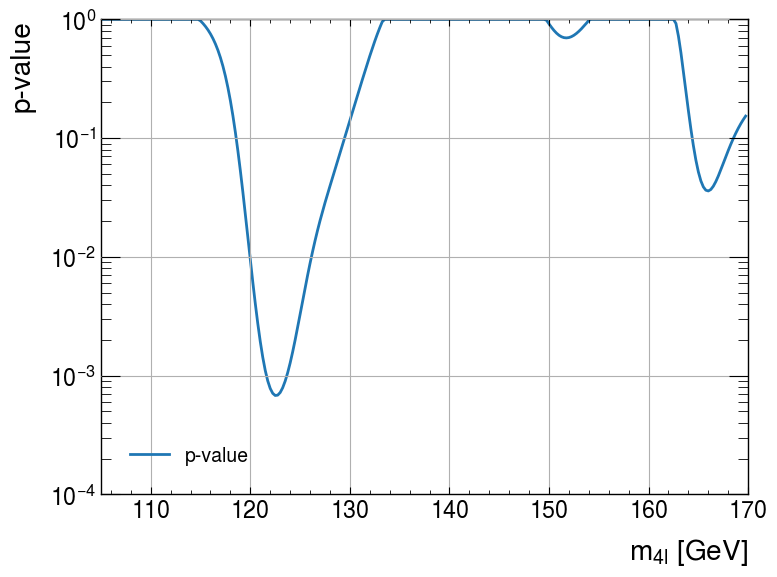

In [9]:
data = r.TFile.Open('data.root')
mc_sig = r.TFile.Open('rootfiles/mc_sig.root')
mc_bkg = r.TFile.Open('rootfiles/mc_bkg.root')
ran = [24, 80, 170]
scan_ran = [105, 170]

for channel in ['tot_4l', 'eeee', 'eemm', 'mmee', 'mmmm', 'em']:
    print(channel)
    h_data = data.Get(channel)
    h_sig = mc_sig.Get(channel)
    h_bkg = mc_bkg.Get(channel)

    sig_fitval = fit_sig(h_sig, ran)
    bkg_fitval = fit_bkg(h_bkg, ran)
    p_val, test = fit(h_data, ran, sig_fitval, bkg_fitval)
    draw(h_data, p_val)
    break  # Only resultig in the sum of four channel ('eeee', 'eemm', 'mmee', 'mmmm')